# Hands on PyTorch

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

import numpy as np
import random

import PIL
from PIL import Image, ImageOps, ImageFilter

plt.ion()

In [2]:
!pip install fiftyone

In [ ]:
import fiftyone as fo
import fiftyone.zoo as foz

training_size = 372
validation_size = 64
testing_size = 64

In [5]:
#Dog's picture dataset

dataset_dog_train = foz.load_zoo_dataset(
    "open-images-v6", 
    "train", 
    label_types=["classifications"], 
    classes = ["Dog"],
    max_samples=training_size,
    seed=51,
    shuffle=True,
    dataset_name="open-images-dog-train",
)

dataset_dog_validation = foz.load_zoo_dataset(
    "open-images-v6", 
    "validation", 
    label_types=["classifications"], 
    classes = ["Dog"],
    max_samples=validation_size,
    seed=51,
    shuffle=True,
    dataset_name="open-images-dog-validation",
)

dataset_dog_test = foz.load_zoo_dataset(
    "open-images-v6", 
    "test", 
    label_types=["classifications"], 
    classes = ["Dog"],
    max_samples=testing_size,
    seed=51,
    shuffle=True,
    dataset_name="open-images-dog-test",
)

 100% |█████████████████| 372/372 [4.0m elapsed, 0s remaining, 2.3 samples/s]      
Found 372 samples
Dataset info written to '/Users/martinvielvoye/fiftyone/open-images-v6/info.json'
Loading existing dataset 'open-images-dog'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use
All samples already downloaded
Found 64 samples
Dataset info written to '/Users/martinvielvoye/fiftyone/open-images-v6/info.json'
Loading existing dataset 'open-images-dog'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use
 100% |███████████████████| 64/64 [37.5s elapsed, 0s remaining, 2.5 samples/s]      
Found 64 samples
Dataset info written to '/Users/martinvielvoye/fiftyone/open-images-v6/info.json'
Loading existing dataset 'open-images-dog'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [8]:
# Cat's pictures dataset

dataset_cat_train = foz.load_zoo_dataset(
    "open-images-v6", 
    "train", 
    label_types=["classifications"], 
    classes = ["Cat"],
    max_samples=training_size,
    seed=51,
    shuffle=True,
    dataset_name="open-images-cat-train",
)

dataset_cat_validation = foz.load_zoo_dataset(
    "open-images-v6", 
    "validation", 
    label_types=["classifications"], 
    classes = ["Cat"],
    max_samples=validation_size,
    seed=51,
    shuffle=True,
    dataset_name="open-images-cat-validation",
)

dataset_cat_test = foz.load_zoo_dataset(
    "open-images-v6", 
    "test", 
    label_types=["classifications"], 
    classes = ["Cat"],
    max_samples=testing_size,
    seed=51,
    shuffle=True,
    dataset_name="open-images-cat-test",
)

All samples already downloaded
Found 372 samples
Dataset info written to '/Users/martinvielvoye/fiftyone/open-images-v6/info.json'
Loading existing dataset 'open-images-cat'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use
All samples already downloaded
Found 64 samples
Dataset info written to '/Users/martinvielvoye/fiftyone/open-images-v6/info.json'
Loading existing dataset 'open-images-cat'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use
All samples already downloaded
Found 64 samples
Dataset info written to '/Users/martinvielvoye/fiftyone/open-images-v6/info.json'
Loading existing dataset 'open-images-cat'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [6]:
dog_session = fo.launch_app(dataset_dog)

In [8]:
path_to_export_dog = "./image_folder/dog"
label_field = "ground_truth"

dataset_dog.export(
    export_dir=path_to_export_dog, dataset_type=fo.types.ImageDirectory, label_field=label_field
)

 100% |█████████████████| 300/300 [726.0ms elapsed, 0s remaining, 413.2 samples/s]      


In [10]:
first_layer = ["train", "validation", "test"]
second_layer = ["Dog", "Cat"]
photo_variables = [dataset_dog_train, dataset_cat_train, dataset_dog_validation, dataset_cat_validation, dataset_dog_test, dataset_cat_test]

ind = 0

path_to_export_base  = "./image_folder/"
label_field = "ground_truth"

for layer_one in first_layer: 
    for layer_two in second_layer:
        export_path = path_to_export_base + layer_one + "/" + layer_two
        
        photo_variables[ind].export(export_dir=export_path, dataset_type=fo.types.ImageDirectory, label_field=label_field)
        
        ind = ind + 1
        

 100% |█████████████████| 500/500 [850.8ms elapsed, 0s remaining, 587.7 samples/s]      
 100% |█████████████████| 413/413 [708.3ms elapsed, 0s remaining, 583.1 samples/s]      
 100% |█████████████████| 500/500 [600.4ms elapsed, 0s remaining, 832.8 samples/s]      
 100% |█████████████████| 413/413 [448.5ms elapsed, 0s remaining, 920.7 samples/s]      
 100% |█████████████████| 500/500 [510.8ms elapsed, 0s remaining, 978.8 samples/s]      
 100% |█████████████████| 413/413 [391.3ms elapsed, 0s remaining, 1.1K samples/s]      


## Quick Data Import

In [13]:
path_to_data = "./image_folder"

quick_image_folder = {x: datasets.ImageFolder(os.path.join(path_to_data, x))
                  for x in ['train', 'validation', 'test']}

quick_dataset_torch = {x: torch.utils.data.DataLoader(quick_image_folder[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'validation', 'test']}

In [25]:
quick_dataset_torch['train'].dataset[0]

(<PIL.Image.Image image mode=RGB size=1024x768 at 0x10E743880>, 0)

In [61]:
def plot_cats_n_dogs(data, dataset_section = "train", flag = False):
    labels_map = {
        0: 'Cat',
        1: 'Dog'
    }
    
    data_var = data[dataset_section].dataset
    
    print(len(data_var))

    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(data_var), size=(1,)).item()
        img, label = data_var[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(labels_map[label])
        if flag : 
            plt.imshow(img, cmap="gray")
        else : 
            plt.imshow(img.permute(1, 2, 0))
    plt.show()
    
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

913


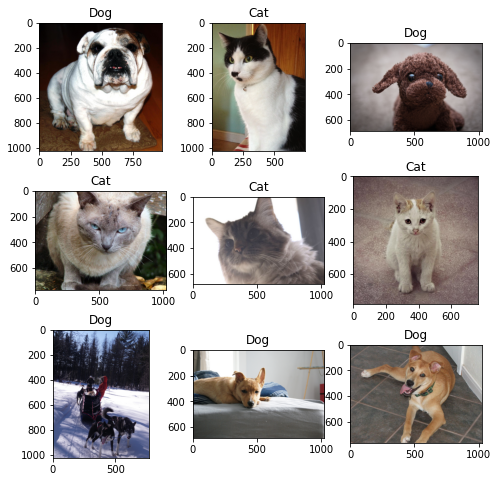

In [34]:
plot_cats_n_dogs(quick_dataset_torch, 'train', True)

## Data Manipulation

In [36]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

def BlurTransform(self, limit):
    thresh = random.uniform(0, 1)
    if(thresh < limit):
        image = self.filter(ImageFilter.BoxBlur(1))
        return image
    else : 
        return self

    
def load_complete_dataset(path):
    data_path = path
    train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=torchvision.transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(),
            transforms.Lambda(lambda x: BlurTransform(x, 0.5)),
            Rescale(256),
            RandomCrop(224),
            transforms.ToTensor(),
            transforms.RandomErasing(0.3),
        ])
    )
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = False)

    return train_loader

In [52]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
#        transforms.Lambda(lambda x: BlurTransform(x, 0.5)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [53]:
path_to_data = "./image_folder"

image_datasets = {x: datasets.ImageFolder(os.path.join(path_to_data, x),
                                          data_transforms[x])
                  for x in ['train', 'validation', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'validation', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation', 'test']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

913
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


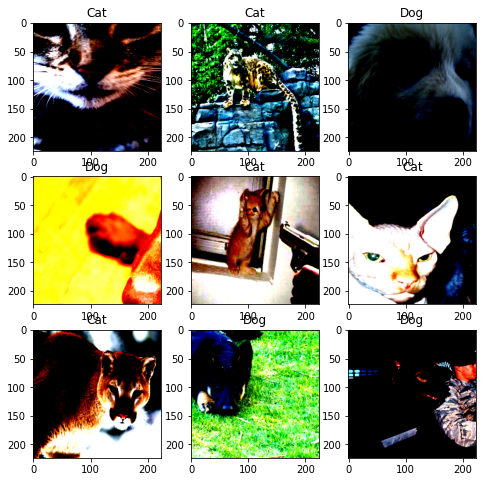

In [54]:
plot_cats_n_dogs(dataloaders)

## Training Process

In [55]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best validation Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [56]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['validation']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Transfer Learning

In [57]:
from torchvision import models

model_ft = models.resnet50(pretrained=True)

In [58]:
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [59]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=6)

Epoch 0/24
----------


/usr/local/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.4268 Acc: 0.7831
validation Loss: 0.1754 Acc: 0.9376

Epoch 1/24
----------
train Loss: 0.2858 Acc: 0.8839
validation Loss: 0.1484 Acc: 0.9496

Epoch 2/24
----------
train Loss: 0.2268 Acc: 0.9003
validation Loss: 0.1342 Acc: 0.9518

Epoch 3/24
----------
train Loss: 0.2385 Acc: 0.9036
validation Loss: 0.1123 Acc: 0.9562

Epoch 4/24
----------
train Loss: 0.2611 Acc: 0.8992
validation Loss: 0.1217 Acc: 0.9540

Epoch 5/24
----------
train Loss: 0.2273 Acc: 0.9069
validation Loss: 0.0867 Acc: 0.9595

Epoch 6/24
----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x117fe2c10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/local/Cellar/python@3.9/3.9.5/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/local/Cellar/python@3.9/3.9.5/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/local/Cellar/python@3.9/3.9.5/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/connection.py", line 936, in wait
    ready = selector.select(timeout)
  File "/usr/local/Cellar/p

KeyboardInterrupt: 

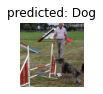

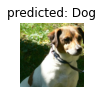

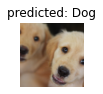

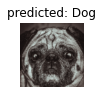

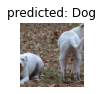

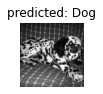

In [62]:
visualize_model(model_ft)

In [77]:
def evaluate_test(model, phase = "test"):
    since = time.time()

    model.eval()   # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    index = 0

    # Iterate over data.
    for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)


        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
            
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        # deep copy the model
        if phase == 'test' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        index += 1
        print(index)

    time_elapsed = time.time() - since
    print('Tests completed in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Test Accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [78]:
res = evaluate_test(model_ft)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
Training complete in 2m 17s
Best validation Acc: 0.959474
